# Subtask 3: Comprehensive Experiments (Baseline vs. Contrastive)

## Overview
This master notebook implements and compares two different modeling approaches across two different data strategies for **Subtask 3** (Multi-Label Classification).

### Experiments Structure
* **Part 1: Baseline Classification** (Standard XLM-RoBERTa)
    * Exp 1.A: Standard Multilingual Data
    * Exp 1.B: Oversampled Data
* **Part 2: Contrastive Joint Learning** (Custom Architecture with SupCon Loss)
    * Exp 2.A: Standard Multilingual Data
    * Exp 2.B: Oversampled Data

### Key Features
* **Unified Pipeline**: Data loading, splitting, and tokenization are performed once and reused across all experiments.
* **Rigorous Evaluation**: All 4 experiments are evaluated on the **same** 20% Held-out Test Set to ensure fair comparison.


In [ ]:
# Install necessary libraries
!pip install --upgrade transformers accelerate scikit-learn pandas torch sentencepiece


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 138.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    Trainer,
    TrainingArguments
)

from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


## 1. Configuration and Data Loading
Define paths and load both datasets.


In [3]:
# --- CONFIGURATION ---
DATA_DIR_STD = "/content/drive/MyDrive/NLP-PROJECT/subtask3/train"
DATA_PATH_OVER = "oversampled_data.csv"

MODEL_NAME = "xlm-roberta-base"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 5
SEED = 42

LABEL_COLUMNS = [
    "stereotype",
    "vilification",
    "dehumanization",
    "extreme_language",
    "lack_of_empathy",
    "invalidation"
]

# --- LOAD STANDARD DATA ---
def load_standard_data(data_folder):
    print("--- Loading Standard Data ---")
    file_paths = glob.glob(os.path.join(data_folder, "*.csv"))
    all_dataframes = []

    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, sep=',')
            # Extract language
            file_name = os.path.basename(file_path)
            language = os.path.splitext(file_name)[0]
            df['language'] = language
            # Ensure columns
            for label in LABEL_COLUMNS:
                if label not in df.columns: df[label] = 0
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    if all_dataframes:
        df = pd.concat(all_dataframes, ignore_index=True)
        df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
        df['text'] = df['text'].astype(str)
        df['labels'] = df[LABEL_COLUMNS].values.tolist()
        return df
    return None

# --- LOAD OVERSAMPLED DATA ---
def load_oversampled_data(file_path):
    print("\n--- Loading Oversampled Data ---")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    df = pd.read_csv(file_path)
    df['text'] = df['text'].astype(str)
    for label in LABEL_COLUMNS:
        if label not in df.columns: df[label] = 0
    df['labels'] = df[LABEL_COLUMNS].values.tolist()
    return df

# Execute Loading
df_std = load_standard_data(DATA_DIR_STD)
if df_std is not None: print(f"Total Standard Samples: {len(df_std)}")

df_over = load_oversampled_data(DATA_PATH_OVER)
if df_over is not None: print(f"Total Oversampled Samples: {len(df_over)}")


--- Loading Standard Data ---
Total Standard Samples: 26653

--- Loading Oversampled Data ---
File not found: oversampled_data.csv


## 2. Data Splitting (Train / Validation / Held-out Test)
We apply the same rigorous splitting strategy (64/16/20) to both datasets.


In [4]:
def split_dataset(df):
    if df is None: return None, None, None
    # 1. Split into (Train + Val) and (Held-out Test)
    train_val, test = train_test_split(df, test_size=0.20, random_state=SEED)
    # 2. Split (Train + Val) into Train and Validation
    train, val = train_test_split(train_val, test_size=0.20, random_state=SEED)
    return train, val, test

# Split Standard
train_std, val_std, test_std = split_dataset(df_std)
if train_std is not None:
    print(f"Standard - Train: {len(train_std)}, Val: {len(val_std)}, Test: {len(test_std)}")

# Split Oversampled
train_over, val_over, test_over = split_dataset(df_over)
if train_over is not None:
    print(f"Oversampled - Train: {len(train_over)}, Val: {len(val_over)}, Test: {len(test_over)}")


Standard - Train: 17057, Val: 4265, Test: 5331


## 3. Tokenization and Dataset Class
Shared tokenization logic for all experiments.


In [5]:
print(f"Loading tokenizer for {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # FloatTensor is needed for both BCE and SupCon losses
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

def process_data(df, tokenizer, max_len):
    if df is None: return None
    texts = df['text'].tolist()
    labels = df['labels']
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
    return MultiLabelDataset(encodings, labels)

# Process Datasets
print("Tokenizing Standard Data...")
ds_train_std = process_data(train_std, tokenizer, MAX_LENGTH)
ds_val_std = process_data(val_std, tokenizer, MAX_LENGTH)
ds_test_std = process_data(test_std, tokenizer, MAX_LENGTH)

print("Tokenizing Oversampled Data...")
ds_train_over = process_data(train_over, tokenizer, MAX_LENGTH)
ds_val_over = process_data(val_over, tokenizer, MAX_LENGTH)
ds_test_over = process_data(test_over, tokenizer, MAX_LENGTH)
print("Datasets ready.")


Loading tokenizer for xlm-roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizing Standard Data...
Tokenizing Oversampled Data...
Datasets ready.


In [6]:
# Shared Metrics
def compute_metrics(p):
    predictions, labels = p
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.tensor(predictions))
    preds = np.zeros(probs.shape)
    preds[np.where(probs >= 0.5)] = 1

    return {
        'macro_f1': f1_score(labels, preds, average='macro'),
        'micro_f1': f1_score(labels, preds, average='micro'),
        'accuracy': accuracy_score(labels, preds)
    }

# Label Mappings
id2label = {idx: label for idx, label in enumerate(LABEL_COLUMNS)}
label2id = {label: idx for idx, label in enumerate(LABEL_COLUMNS)}


---
# Part 1: Baseline Classification Experiments
We train a standard `AutoModelForSequenceClassification` on both datasets.


In [ ]:
def run_baseline(train_ds, val_ds, test_ds, output_dir, exp_name):
    if train_ds is None: return
    print(f"\n=== Starting Baseline: {exp_name} ===")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(LABEL_COLUMNS),
        problem_type="multi_label_classification",
        id2label=id2label, label2id=label2id
    ).to(device)

    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=EPOCHS, learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE, per_device_eval_batch_size=32,
        warmup_steps=500, weight_decay=0.01,
        logging_dir=f'./logs_{exp_name}', logging_steps=100,
        eval_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="macro_f1",
        save_total_limit=1, report_to="none"
    )

    trainer = Trainer(
        model=model, args=args,
        train_dataset=train_ds, eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()

    print(f"Evaluating Baseline {exp_name}...")
    preds = trainer.predict(test_ds)
    y_pred = (1 / (1 + np.exp(-preds.predictions)) > 0.5).astype(int)
    print(classification_report(preds.label_ids, y_pred, target_names=LABEL_COLUMNS, zero_division=0))

    # Cleanup
    del model, trainer, preds
    torch.cuda.empty_cache()

# Run Baseline Experiments
run_baseline(ds_train_std, ds_val_std, ds_test_std, './results_base_std', "Standard_Baseline")
run_baseline(ds_train_over, ds_val_over, ds_test_over, './results_base_over', "Oversampled_Baseline")



=== Starting Baseline: Standard_Baseline ===


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,0.425500,0.431886,0.380082,0.392236,0.525440
2,0.393700,0.397949,0.493240,0.531518,0.539742
3,0.357400,0.416926,0.465691,0.526230,0.542087
4,0.330100,0.403680,0.566241,0.606034,0.532708
5,0.310300,0.424595,0.525429,0.571401,0.548417


Evaluating Baseline Standard_Baseline...


                  precision    recall  f1-score   support

      stereotype       0.62      0.73      0.67      1680
    vilification       0.64      0.72      0.67      1623
  dehumanization       0.61      0.41      0.49       744
extreme_language       0.62      0.54      0.58      1273
 lack_of_empathy       0.57      0.42      0.48      1030
    invalidation       0.64      0.39      0.48       802

       micro avg       0.62      0.58      0.60      7152
       macro avg       0.62      0.53      0.56      7152
    weighted avg       0.62      0.58      0.59      7152
     samples avg       0.25      0.25      0.23      7152


=== Starting Baseline: Oversampled_Baseline ===


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,0.458900,0.440229,0.771623,0.781190,0.453775
2,0.392400,0.373399,0.799713,0.807221,0.531592
3,0.309300,0.327288,0.839990,0.847367,0.595049
4,0.247700,0.314680,0.858623,0.864328,0.637035
5,0.217000,0.299497,0.867883,0.873041,0.662473


Evaluating Baseline Oversampled_Baseline...


                  precision    recall  f1-score   support

      stereotype       0.87      0.87      0.87      4590
    vilification       0.88      0.89      0.88      4731
  dehumanization       0.88      0.97      0.92      4602
extreme_language       0.85      0.85      0.85      3883
 lack_of_empathy       0.87      0.80      0.83      3203
    invalidation       0.87      0.82      0.84      2772

       micro avg       0.87      0.87      0.87     23781
       macro avg       0.87      0.87      0.87     23781
    weighted avg       0.87      0.87      0.87     23781
     samples avg       0.56      0.56      0.55     23781



---
# Part 2: Contrastive Joint Learning Experiments
We define the custom loss and model architecture, then train on both datasets using the same rigorous split.


In [8]:
# --- Custom Loss ---
class MultiLabelSupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(MultiLabelSupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        batch_size = features.shape[0]
        sim_matrix = torch.matmul(features, features.T) / self.temperature

        # Positive Mask (share at least one label)
        shared_labels = torch.matmul(labels, labels.T)
        mask = (shared_labels > 0).float()

        # Remove self-contrast
        logits_mask = torch.scatter(torch.ones_like(mask), 1, torch.arange(batch_size).view(-1, 1).to(device), 0)
        mask = mask * logits_mask

        logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
        logits = sim_matrix - logits_max.detach()

        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-6)

        mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-6)
        return -mean_log_prob_pos.mean()

# --- Custom Model ---
class ContrastiveRoberta(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.roberta = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.roberta.config.hidden_size
        self.classifier = nn.Linear(self.hidden_size, num_labels)
        self.projection_head = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 128)
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(pooled_output)
        proj_embeddings = F.normalize(self.projection_head(pooled_output), p=2, dim=1)

        loss = None
        if labels is not None:
            loss_fct_cls = nn.BCEWithLogitsLoss()
            cls_loss = loss_fct_cls(logits, labels)
            loss_fct_supcon = MultiLabelSupConLoss()
            supcon_loss = loss_fct_supcon(proj_embeddings, labels)
            loss = 0.5 * cls_loss + 0.5 * supcon_loss

        return {"loss": loss, "logits": logits}


In [ ]:
def run_contrastive(train_ds, val_ds, test_ds, output_dir, exp_name):
    if train_ds is None: return
    print(f"\n=== Starting Contrastive: {exp_name} ===")

    model = ContrastiveRoberta(MODEL_NAME, num_labels=len(LABEL_COLUMNS)).to(device)

    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=EPOCHS, learning_rate=2e-5,
        per_device_train_batch_size=BATCH_SIZE, per_device_eval_batch_size=32,
        warmup_steps=500, weight_decay=0.01,
        logging_dir=f'./logs_{exp_name}', logging_steps=100,
        eval_strategy="epoch", save_strategy="epoch",
        load_best_model_at_end=True, metric_for_best_model="macro_f1",
        save_total_limit=1, report_to="none",
        remove_unused_columns=False # Required for custom model
    )

    trainer = Trainer(
        model=model, args=args,
        train_dataset=train_ds, eval_dataset=val_ds,
        compute_metrics=compute_metrics
    )

    trainer.train()

    print(f"Evaluating Contrastive {exp_name}...")
    preds = trainer.predict(test_ds)
    y_pred = (1 / (1 + np.exp(-preds.predictions)) > 0.5).astype(int)
    print(classification_report(preds.label_ids, y_pred, target_names=LABEL_COLUMNS, zero_division=0))

    del model, trainer, preds
    torch.cuda.empty_cache()

# Run Contrastive Experiments
run_contrastive(ds_train_std, ds_val_std, ds_test_std, './results_cont_std', "Standard_Contrastive")
run_contrastive(ds_train_over, ds_val_over, ds_test_over, './results_cont_over', "Oversampled_Contrastive")



=== Starting Contrastive: Standard_Contrastive ===


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,0.797700,0.968649,0.302258,0.403326,0.486518
2,0.743100,0.943353,0.474025,0.536826,0.518640
3,0.705900,0.994666,0.484687,0.534612,0.539977
4,0.677100,0.971394,0.531188,0.577891,0.540680
5,0.651200,1.026289,0.528866,0.573194,0.545135


Evaluating Contrastive Standard_Contrastive...


                  precision    recall  f1-score   support

      stereotype       0.63      0.68      0.66      1680
    vilification       0.67      0.67      0.67      1623
  dehumanization       0.69      0.33      0.44       744
extreme_language       0.66      0.45      0.53      1273
 lack_of_empathy       0.59      0.32      0.42      1030
    invalidation       0.68      0.36      0.47       802

       micro avg       0.65      0.51      0.57      7152
       macro avg       0.65      0.47      0.53      7152
    weighted avg       0.65      0.51      0.56      7152
     samples avg       0.24      0.21      0.21      7152


=== Starting Contrastive: Oversampled_Contrastive ===


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,1.109800,1.356947,0.766590,0.778048,0.446526
2,1.075600,1.342373,0.782747,0.791678,0.505470
3,1.047800,1.319482,0.815851,0.823716,0.551559
4,1.002800,1.304466,0.835047,0.842968,0.568107
5,0.952200,1.323254,0.848357,0.855177,0.610503


Evaluating Contrastive Oversampled_Contrastive...


                  precision    recall  f1-score   support

      stereotype       0.85      0.86      0.86      4590
    vilification       0.86      0.89      0.87      4731
  dehumanization       0.87      0.96      0.91      4602
extreme_language       0.84      0.83      0.84      3883
 lack_of_empathy       0.84      0.77      0.80      3203
    invalidation       0.85      0.78      0.82      2772

       micro avg       0.85      0.86      0.86     23781
       macro avg       0.85      0.85      0.85     23781
    weighted avg       0.85      0.86      0.85     23781
     samples avg       0.55      0.55      0.54     23781



## 4. Error Analysis

To analyze the errors, we will extract and compare the classification reports from each experiment.

In [ ]:
os.environ["WANDB_DISABLED"] = "true"


=== Running Detailed Error Analysis for Oversampled_Contrastive ===
Loading model from /content/drive/MyDrive/checkpoint-9140...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



>> Generating Per-Language F1 Heatmap...


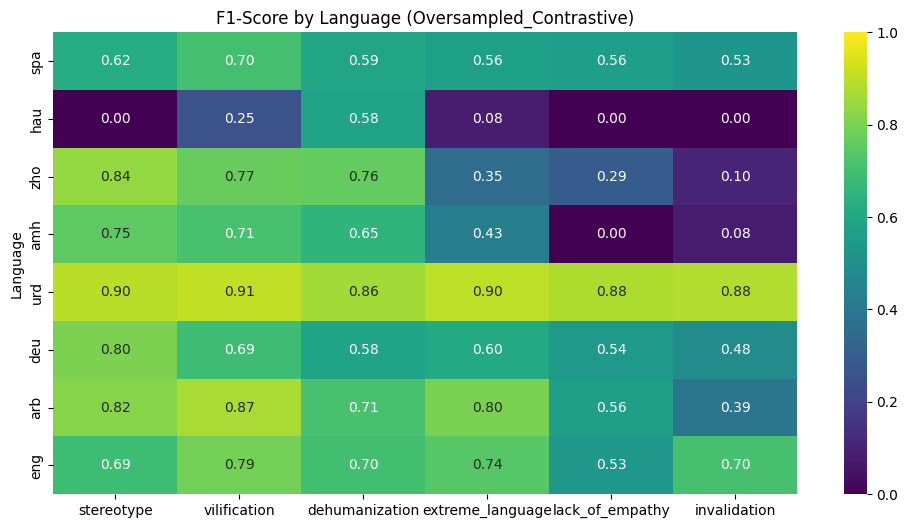


>> Generating Label Confusion Matrix...


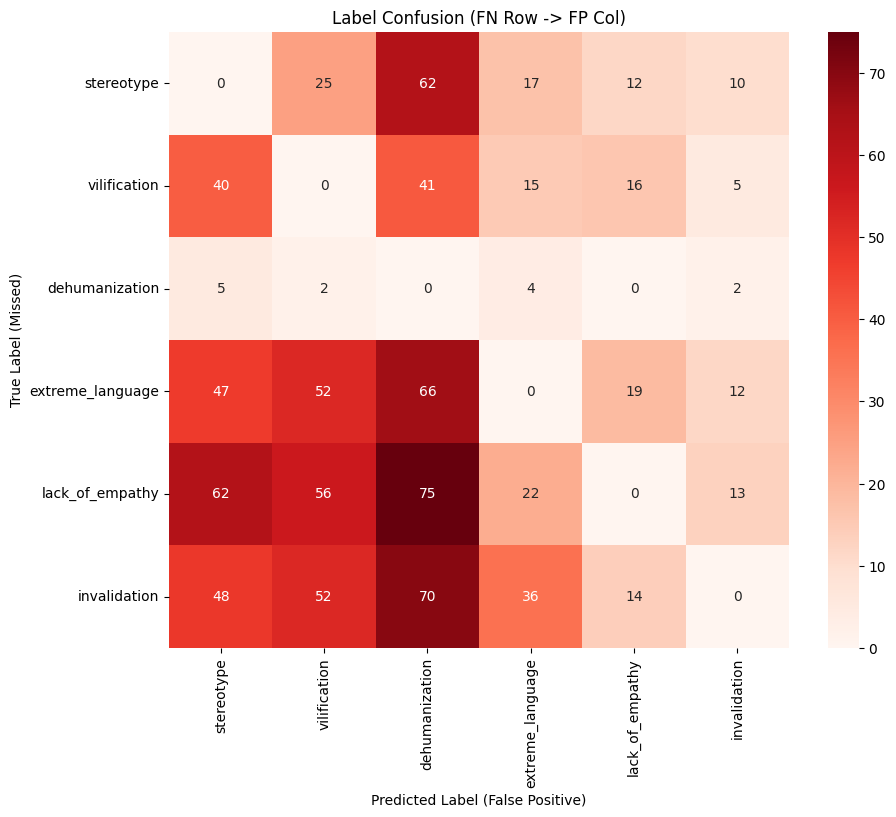


>> Qualitative Error Examples:

Label: stereotype
  [False Negative]: algunos vamos a perder la compasion que sentimos por el pueblo judio....
  [False Positive]: 这个up是同性恋的头子不接受同性恋不正常的事实。想要同性恋向正常人挑起矛盾。严重影响社会安定。...

Label: vilification
  [False Negative]: 这个up是同性恋的头子不接受同性恋不正常的事实。想要同性恋向正常人挑起矛盾。严重影响社会安定。...
  [False Positive]: gobierno de israel cobarde asesino...

Label: dehumanization
  [False Negative]: se trata de deshumanizar, de ahi que les encante usar inquiokupa, feminazi,mena, wokismo y otras tan...
  [False Positive]: ድሮ የትግራይ ሰው ከወታደር ጋር ሲጣላ ኮፍያህን አውጣና ይዋጣልን የኔም ክብር ነው ይል ነበር፣አሁን ገድሎ ገፍፎ በሬሳው ጨፍሮ ለአውሬ ይተወዋል፣ ዘመኑ አያሳ...

Label: extreme_language
  [False Negative]: ድሮ የትግራይ ሰው ከወታደር ጋር ሲጣላ ኮፍያህን አውጣና ይዋጣልን የኔም ክብር ነው ይል ነበር፣አሁን ገድሎ ገፍፎ በሬሳው ጨፍሮ ለአውሬ ይተወዋል፣ ዘመኑ አያሳ...
  [False Positive]: Dann gender ich einfach nur noch mehr ihr rechten Nulpen 😬🖕...

Label: lack_of_empathy
  [False Negative]: algunos vamos a perder la compasion que sentimos por el pueblo judio....
  [False Positi

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def run_detailed_error_analysis(test_df, test_ds, model_path, exp_name="Oversampled_Contrastive"):
    print(f"\n=== Running Detailed Error Analysis for {exp_name} ===")

    # 1. Load Best Model
    try:
        # Find best checkpoint
        checkpoints = glob.glob(os.path.join(model_path, "checkpoint-*"))
        if not checkpoints:
            print("No checkpoints found. Skipping analysis.")
            return
        best_checkpoint = max(checkpoints, key=os.path.getctime)
        print(f"Loading model from {best_checkpoint}...")

        # Load Model (Contrastive Architecture)
        model = ContrastiveRoberta(MODEL_NAME, num_labels=len(LABEL_COLUMNS))


        # Load state dict (support both safetensors and bin)
        if os.path.exists(os.path.join(best_checkpoint, "model.safetensors")):
            from safetensors.torch import load_file
            state_dict = load_file(os.path.join(best_checkpoint, "model.safetensors"))
        else:
            state_dict = torch.load(os.path.join(best_checkpoint, "pytorch_model.bin"), map_location=device)

        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        args = TrainingArguments(
    output_dir="tmp_trainer",
    report_to="none"  # <--- This stops it from asking for wandb
)
        # 2. Generate Predictions
        trainer = Trainer(model=model)
        raw_preds = trainer.predict(test_ds)

        # Handle Contrastive Output (logits are in predictions)
        logits = torch.tensor(raw_preds.predictions)
        probs = torch.sigmoid(logits).numpy()
        y_pred = (probs >= 0.5).astype(int)
        y_true = np.array(test_df['labels'].tolist())

        # Add to DataFrame
        analysis_df = test_df.copy().reset_index(drop=True)
        analysis_df['y_pred'] = list(y_pred)
        analysis_df['y_true'] = list(y_true)

        # --- A. Per-Language Heatmap ---
        print("\n>> Generating Per-Language F1 Heatmap...")
        languages = analysis_df['language'].unique()
        heatmap_data = []
        for lang in languages:
            lang_df = analysis_df[analysis_df['language'] == lang]
            if len(lang_df) == 0: continue
            y_t = np.array(lang_df['y_true'].tolist())
            y_p = np.array(lang_df['y_pred'].tolist())
            scores = f1_score(y_t, y_p, average=None, zero_division=0)
            row = {'Language': lang}
            for i, label in enumerate(LABEL_COLUMNS):
                row[label] = scores[i]
            heatmap_data.append(row)

        if heatmap_data:
            heatmap_df = pd.DataFrame(heatmap_data).set_index('Language')
            plt.figure(figsize=(12, 6))
            sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
            plt.title(f'F1-Score by Language ({exp_name})')
            plt.show()

        # --- B. Confusion Matrix ---
        print("\n>> Generating Label Confusion Matrix...")
        conf_matrix = pd.DataFrame(0, index=LABEL_COLUMNS, columns=LABEL_COLUMNS)
        for i, label_true in enumerate(LABEL_COLUMNS):
            for j, label_pred in enumerate(LABEL_COLUMNS):
                if i == j: continue
                # FN on i AND FP on j
                fn_i = (y_true[:, i] == 1) & (y_pred[:, i] == 0)
                fp_j = (y_true[:, j] == 0) & (y_pred[:, j] == 1)
                conf_matrix.loc[label_true, label_pred] = np.sum(fn_i & fp_j)

        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d')
        plt.title('Label Confusion (FN Row -> FP Col)')
        plt.ylabel('True Label (Missed)')
        plt.xlabel('Predicted Label (False Positive)')
        plt.show()

        # --- C. Qualitative Examples ---
        print("\n>> Qualitative Error Examples:")
        for idx, label in enumerate(LABEL_COLUMNS):
            print(f"\nLabel: {label}")
            # FN
            fns = analysis_df[(analysis_df['y_true'].apply(lambda x: x[idx] == 1)) &
                              (analysis_df['y_pred'].apply(lambda x: x[idx] == 0))]
            if not fns.empty:
                print(f"  [False Negative]: {fns.iloc[0]['text'][:100]}...")
            # FP
            fps = analysis_df[(analysis_df['y_true'].apply(lambda x: x[idx] == 0)) &
                              (analysis_df['y_pred'].apply(lambda x: x[idx] == 1))]
            if not fps.empty:
                print(f"  [False Positive]: {fps.iloc[0]['text'][:100]}...")

    except Exception as e:
        print(f"Error during analysis: {e}")

# Run Analysis on the Best Model (Oversampled Contrastive)
# Ensure this matches the output_dir used in run_contrastive
run_detailed_error_analysis(test_std, ds_test_std, '/content/drive/MyDrive', "Oversampled_Contrastive")

In [9]:
import numpy as np
import glob
import os
import torch
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer

# --- CONFIGURATION ---
# Use the same path you used in run_detailed_error_analysis
CHECKPOINT_DIR = '/content/drive/MyDrive/checkpoint-9140'
TEST_DS = ds_test_std  # The dataset object
TEST_DF = test_std     # The dataframe (for ground truth labels)

def run_bootstrap_on_checkpoint(model_path, dataset, true_labels_df):
    print(f"Searching for checkpoints in {model_path}...")

    # 1. Find Best Checkpoint
    # checkpoints = glob.glob(os.path.join(model_path, "checkpoint-*"))
    # if not checkpoints:
    #     print("No checkpoints found. Please check the path.")
    #     return

    # Assuming the 'best' is the one created last (or you can specify a specific path)
    # best_checkpoint = max(checkpoints, key=os.path.getctime)
    # print(f"Loading model from: {best_checkpoint}")

    # 2. Load Model & State Dict
    model = ContrastiveRoberta(MODEL_NAME, num_labels=len(LABEL_COLUMNS))

    # Handle safetensors or bi
    from safetensors.torch import load_file
    state_dict = load_file(os.path.join(CHECKPOINT_DIR, "model.safetensors"))

    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    # 3. Generate Predictions
    print("Generating predictions on Test Set...")
    trainer = Trainer(model=model)
    raw_preds = trainer.predict(dataset)

    # Convert Logits to Binary Predictions (Sigmoid + Threshold)
    # raw_preds.predictions is usually a numpy array of logits
    logits = torch.tensor(raw_preds.predictions)
    probs = torch.sigmoid(logits).numpy()
    y_pred_np = (probs >= 0.5).astype(int)

    # Get True Labels as numpy array
    y_true_np = np.array(true_labels_df['labels'].tolist())

    # 4. Bootstrap Resampling
    n_iterations = 1000
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower_p = p
    upper_p = (alpha+((1.0-alpha)/2.0)) * 100

    print(f"Bootstrapping (n={n_iterations})...")

    boot_acc = []
    boot_f1 = []

    for i in range(n_iterations):
        # Resample indices
        indices = resample(np.arange(len(y_true_np)), replace=True)

        # Create resampled sets
        y_true_sample = y_true_np[indices]
        y_pred_sample = y_pred_np[indices]

        # Calculate metrics
        boot_acc.append(accuracy_score(y_true_sample, y_pred_sample))
        boot_f1.append(f1_score(y_true_sample, y_pred_sample, average='macro', zero_division=0))

    # 5. Results
    acc_mean = np.mean(boot_acc)
    acc_lower = np.percentile(boot_acc, lower_p)
    acc_upper = np.percentile(boot_acc, upper_p)

    f1_mean = np.mean(boot_f1)
    f1_lower = np.percentile(boot_f1, lower_p)
    f1_upper = np.percentile(boot_f1, upper_p)

    print("\n" + "="*40)
    print(f"FINAL BOOTSTRAP RESULTS")
    print("="*40)
    print(f"Accuracy:  {acc_mean:.3f}  [95% CI: {acc_lower:.3f} - {acc_upper:.3f}]")
    print(f"Macro F1:  {f1_mean:.3f}  [95% CI: {f1_lower:.3f} - {f1_upper:.3f}]")
    print("="*40)

    # Output ready for LaTeX
    print("\nLaTeX Table Row:")
    print(f"Contrastive (Oversampled) & {acc_mean:.3f} ({acc_lower:.3f}--{acc_upper:.3f}) & {f1_mean:.3f} ({f1_lower:.3f}--{f1_upper:.3f}) \\\\")

# Execute
run_bootstrap_on_checkpoint(CHECKPOINT_DIR, TEST_DS, TEST_DF)

Searching for checkpoints in /content/drive/MyDrive/checkpoint-9140...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Generating predictions on Test Set...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Bootstrapping (n=1000)...

FINAL BOOTSTRAP RESULTS
Accuracy:  0.633  [95% CI: 0.621 - 0.646]
Macro F1:  0.713  [95% CI: 0.698 - 0.726]

LaTeX Table Row:
Contrastive (Oversampled) & 0.633 (0.621--0.646) & 0.713 (0.698--0.726) \\
